## "When are Iterative Gaussian Processes Reliably Accurate?"

by Wesley Maddox, Sanyam Kapoor, Andrew Gordon Wilson

*Beyond First-Order Methods in ML Workshop at ICML 2021*: https://sites.google.com/view/optml-icml2021/accepted-papers?authuser=0

Local link: https://wjmaddox.github.io/assets/iterative_gps_optml.pdf

In [1]:
import torch

import time

import sys
sys.path.append("/home/wesley_m/PyTorch-LBFGS/functions")
from LBFGS import FullBatchLBFGS



## Gaussian Process Intro

\begin{align}
f \sim \mathcal{GP}(\mu_\theta, k_\theta(\mathbf{X}, \mathbf{X}))
\end{align}
\begin{align}
y \sim \mathcal{N}(f, \sigma^2 I)
\end{align}

While extremely flexible models, the catch with GPs is that the kernel function induces a matrix of size $n \times n$ that must be inverted for GP prediction and training.

Predictive equations:
\begin{align}
p(f(\mathbf{X}_\star) \mid \mathbf{X}_\star,& \mathcal{D}, \theta) = \mathcal{N}(\mu(\mathbf{X}_\star), \Sigma(\mathbf{X}_\star)), \label{eq:gp_post} \\
\mu(\mathbf{X}_\star) &= K_{\mathbf{X}_\star, \mathbf{X}} \widehat{K}_{\mathbf{X},\mathbf{X}}^{-1} \mathbf{y}~, \nonumber \\
\Sigma(\mathbf{X}_\star) &= K_{\mathbf{X}_\star, \mathbf{X}_\star} - K_{\mathbf{X}_\star, \mathbf{X}} \widehat{K}_{\mathbf{X},\mathbf{X}}^{-1} K_{\mathbf{X}_\star, \mathbf{X}}^\top ~, \nonumber
\end{align}
where $\widehat{K}_{\mathbf{X},\mathbf{X}} = K_{\mathbf{X},\mathbf{X}} + \sigma^2 \mathbf{I}$.


More specifically, this requires solving $n \times n$ systems of equations of the following form: 
<!-- \begin{align}
\LARGE z = {\widehat{K}_{\mathbf{X},\mathbf{X}} v}
\end{align} -->
\begin{align}
\LARGE {\widehat{K}_{\mathbf{X},\mathbf{X}}} z = v
\end{align}
which naively takes $\mathcal{O}(n^3)$, thus limiting GP regression to generally no more than $\mathcal{O}(10,000)$ data points. 

In [2]:
device = torch.device("cuda:0")
dtype = torch.float

## Iterative Gaussian Processes


**Conjugate Gradients**
- Cutajar et al, 2016: https://arxiv.org/abs/1602.06693
- Gardner et al, NeurIPS, 2018: https://arxiv.org/abs/1809.11165
- Wang et al, NeurIPS, 2019: https://arxiv.org/abs/1903.08114

**Lanczos Decompositions**
- Pleiss et al, ICML, 2018: https://arxiv.org/abs/1803.06058
\begin{align}
\Sigma(\mathbf{X}_\star) &= K_{\mathbf{X}_\star, \mathbf{X}_\star} - K_{\mathbf{X}_\star, \mathbf{X}} \widehat{K}_{\mathbf{X},\mathbf{X}}^{-1} K_{\mathbf{X}_\star, \mathbf{X}}^\top \\
&= K_{\mathbf{X}_\star, \mathbf{X}_\star} - K_{\mathbf{X}_\star, \mathbf{X}} LL^\top K_{\mathbf{X}_\star, \mathbf{X}}^\top,
\end{align}
where $LL^\top \approx \widehat{K}_{\mathbf{X},\mathbf{X}}^{-1}.$ The rank $r$ of the Lanczos decomposition tends to determine the performance of the approximation.


In [3]:
import gpytorch

from bayesian_benchmarks.data import get_regression_data
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels.keops import MaternKernel
from gpytorch.kernels import ScaleKernel
from gpytorch.priors import GammaPrior

In [4]:
data = get_regression_data("wilson_keggundirected")

In [5]:
data.X_train.shape

(57247, 27)

In [6]:
model = SingleTaskGP(
    torch.tensor(data.X_train),
    torch.tensor(data.Y_train),
    covar_module = ScaleKernel(
        MaternKernel(nu=2.5, lengthscale_prior=GammaPrior(3.0, 6.0)),
        outputscale_prior=GammaPrior(2.0, 5.0),
    )
).to(device=device, dtype=dtype)

In [7]:
mll = ExactMarginalLogLikelihood(model.likelihood, model)
optimizer = FullBatchLBFGS(model.parameters(), lr = 1.0)

In [8]:
high_tol_time = []
for i in range(50):
    def closure():
        optimizer.zero_grad()
        with gpytorch.settings.cg_tolerance(0.1):
            loss = -mll(model(*model.train_inputs), model.train_targets).sum()
        return loss
    
    start = time.time()
    loss = closure()
    
    optimizer.step({"closure": closure, "current_loss": loss})
    end = time.time()
    high_tol_time.append(end - start)
    
    if i % 5 == 0:
        print("Step: ", i, "Loss: ", loss.item())

/home/wesley_m/PyTorch-LBFGS/functions/LBFGS.py:257: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554800319/work/torch/csrc/utils/python_arg_parser.cpp:1005.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))


Step:  0 Loss:  1.3389778137207031
Step:  5 Loss:  1.3386880159378052
Step:  10 Loss:  1.3389846086502075
Step:  15 Loss:  1.3383740186691284
Step:  20 Loss:  1.3391427993774414
Step:  25 Loss:  1.3385124206542969
Step:  30 Loss:  1.3386677503585815
Step:  35 Loss:  1.338518738746643
Step:  40 Loss:  1.3386945724487305
Step:  45 Loss:  1.3385530710220337


In [20]:
print("Total Time: ", sum(high_tol_time) / 60)

Total Time:  4.534620594978333


In [9]:
with torch.no_grad():
    posterior = model.posterior(
        torch.tensor(data.X_test, device=device, dtype=dtype)
    )

In [10]:
mse = torch.mean((posterior.mean.cpu() - torch.tensor(data.Y_test))**2)
print(mse)

nll = torch.distributions.Normal(
    posterior.mean, posterior.variance**0.5
).log_prob(torch.tensor(data.Y_test, device=device, dtype=dtype)).mean()
print(nll)

tensor(0.0643, dtype=torch.float64)
tensor(-3.4310, device='cuda:0', grad_fn=<MeanBackward0>)


### Investigating the Predictive Variances

- Kapoor et al, ICML '21 https://arxiv.org/abs/2106.06695
- Sun et al, ICML '21 https://arxiv.org/abs/2106.05992
- Potapczynski et al, ICML, '21 https://arxiv.org/abs/2102.06695

(array([1918.,  158.,  169.,  179.,  215.,  265.,  300.,  397.,  521.,
        2239.]),
 array([0.00088435, 0.07011063, 0.13933691, 0.20856321, 0.27778947,
        0.34701577, 0.41624206, 0.48546833, 0.5546946 , 0.6239209 ,
        0.6931472 ], dtype=float32),
 <BarContainer object of 10 artists>)

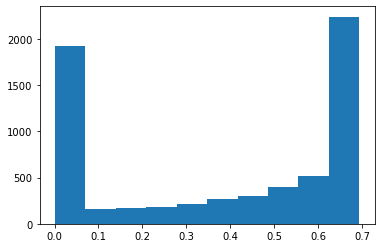

In [11]:
import matplotlib.pyplot as plt

plt.hist(posterior.variance.cpu().detach().numpy())

While the MSE is pretty small, the NLL is much lower than the MSE would natively suggest. Indeed, investigating the NLL, we can immediately spot what's going on: 

\begin{align}
\LARGE \mathrm{NLL}(\sigma^2) := \frac{1}{2}\log \sigma^2 + \frac{1}{2\sigma^2}(\mu - y)^2~,
\end{align}

In [13]:
rank_test = [10, 50, 100, 1000, 5000, 10000]
nll_rank_list = []

for rank in rank_test:
    model.train() # to clear any caches
    with gpytorch.settings.max_root_decomposition_size(rank):
        posterior = model.posterior(
            torch.tensor(data.X_test, device=device, dtype=dtype)
        )
        nll = torch.distributions.Normal(
            posterior.mean, 
            posterior.variance**0.5
        ).log_prob(
            torch.tensor(data.Y_test, device=device, dtype=dtype)
        ).mean()
        nll_rank_list.append(nll)

Text(0.5, 1.0, 'Entire Test Set')

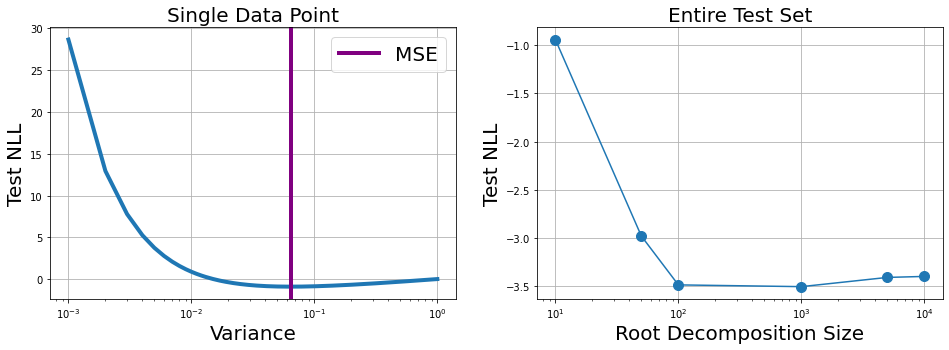

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

var_range = torch.linspace(0.001, 1.0, 1000)
ax[0].plot(
    var_range, 
    0.5 * (var_range.log() + mse.cpu().detach() / var_range), 
    linewidth = 4
)
ax[0].axvline(mse.cpu().detach(), color = "purple", linewidth = 4, label = "MSE")
ax[0].legend(fontsize = 20)
ax[0].semilogx()
ax[0].set_xlabel("Variance", fontsize = 20)
ax[0].set_ylabel("Test NLL", fontsize = 20)
ax[0].grid()

ax[0].set_title("Single Data Point", fontsize = 20)

ax[1].plot(
    rank_test, 
    [x.detach().cpu() for x in nll_rank_list], 
    marker = ".", 
    markersize = 20
)
ax[1].semilogx()
ax[1].set_xlabel("Root Decomposition Size", fontsize = 20)
ax[1].set_ylabel("Test NLL", fontsize = 20)
ax[1].grid()
ax[1].set_title("Entire Test Set", fontsize = 20)


### Investigating the Predictive Means

Finally, we close by demonstrating the effect of the predictive means using the conjugate gradients tolerance threshold.

In [15]:
def mock_predictive_mean(test_X):
    # faked mean cache
    model.train()
    train_dist = model.likelihood(model(*model.train_inputs))
    train_mean, train_train_covar = train_dist.loc, train_dist.lazy_covariance_matrix
    train_labels_offset = (
        model.train_targets - train_mean
    ).unsqueeze(-1)
    
    # compute z = \hat K^{-1} (y - \mu)
    mean_cache = train_train_covar.evaluate_kernel().inv_matmul(
        train_labels_offset
    ).squeeze(-1)
    
    # compute K_{test, train} z
    test_train_covar = model.covar_module(test_X, *model.train_inputs)
    test_pred_zero_mean = test_train_covar.matmul(mean_cache)
    
    return train_dist.loc[0] * torch.ones_like(
        test_pred_zero_mean
    ) + test_pred_zero_mean

In [16]:
cg_test = [1.0, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]
mse_tol_list = []

# we iterate over the set of cg tolerances
for tol in cg_test:
    with gpytorch.settings.cg_tolerance(tol), \
        gpytorch.settings.skip_posterior_variances(True):
        mocked_mean = mock_predictive_mean(
            torch.tensor(data.X_test, device=device, dtype=dtype)
        )
        mse = torch.mean(
            (mocked_mean.cpu().unsqueeze(-1) - \
             torch.tensor(data.Y_test)
        )**2).detach()
    mse_tol_list.append(mse)

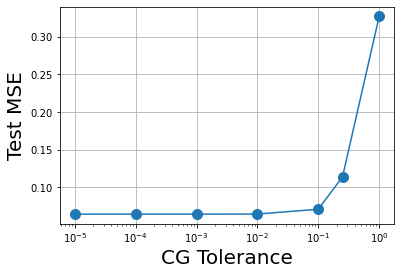

In [17]:
plt.plot(cg_test, mse_tol_list, marker = ".", markersize = 20)
plt.semilogx()

plt.xlabel("CG Tolerance", fontsize = 20)
plt.ylabel("Test MSE", fontsize = 20)
plt.grid()